# Treinamento

Treinamento dos métodos implementados

TODO
- Precisamos otimizar os hyper parametros
- Muito overfitting: Como fazer o modelo generalizar melhor nas tasks de teste? 
- Data Augmentation (?)
- Testar outros métodos de regularização

In [1]:
from methods.prototypical_networks import PrototypicalNetworks as Method
# from methods.matching_networks import MatchingNetworks as Method

In [2]:
import time
import timm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from trainer import train_step, validate
from data.data_manager import BRSETManager

In [3]:
TRAINING_CLASSES = ['diabetic_retinopathy',
                        'scar', 'amd', 'hypertensive_retinopathy', 'drusens', 
                        'myopic_fundus', 'increased_cup_disc', 'other']
TEST_CLASSES = ['hemorrhage', 'vascular_occlusion', 'nevus', 'healthy']

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Parametros

In [6]:
ways = 2
shots = 5
model_type = 'resnet50.a3_in1k'

In [7]:
batch_size = ways*shots

## Modelo

In [8]:
backbone = timm.create_model(model_type, pretrained=True)
backbone.reset_classifier(num_classes=0) # remove a head do modelo

model = Method(backbone).to(device)

## Dataloader

In [9]:
if model_type == "resnet50.a3_in1k" or model_type == "swin_s3_tiny_224.ms_in1k": 
    mean_val, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif model_type == "vit_small_patch32_224.augreg_in21k_ft_in1k":
    mean_val, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
manager = BRSETManager(TRAINING_CLASSES, TEST_CLASSES, shots, ways, mean_val, std, 
                       augment=None, batch_size=batch_size, seed=seed)

## Treinamento

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
if Method.__name__ == "MatchingNetworks":
    criterion = nn.NLLLoss()    # Negative Log Likelihood 
else:
    criterion = nn.CrossEntropyLoss()

episodes = 500
epochs = 20
validate_every = 2

In [13]:
train_logs = []
val_logs = []

model.train()
start_time = time.time()

for epoch in range(epochs):
    total_loss, total_acc = 0, 0
    train_time = time.time()

    # treinamento
    model.train()
    for episode in range(episodes):
        loss, acc = train_step(manager, model, optimizer, criterion, device)
        total_loss += loss
        total_acc += acc
        print(f'Episodio {episode + 1}/{episodes}', end='\r')

    loss = total_loss / episodes
    acc = total_acc / episodes
    print(f"Epoch {epoch + 1} - Loss: {loss:.3f} - Acc: {acc:.2f} - Tempo: {time.time() - train_time:.0f}s")
    train_logs.append((epoch + 1, loss, acc))

    # validacao
    if (epoch + 1) % validate_every == 0:
        val_time = time.time()
        model.eval()
        val_loss, val_acc = validate(manager, model, criterion, device)
        print(f"Validation - Loss: {val_loss:.3f} - Acc: {val_acc:.2f} - Tempo: {time.time() - val_time:.0f}s\n")
        val_logs.append((epoch + 1, val_loss, val_acc))
        
print(f'\nDemorou: {time.time() - start_time:.2f}s')

Epoch 1 - Loss: 1.517 - Acc: 0.65 - Tempo: 44s
Epoch 2 - Loss: 1.453 - Acc: 0.71 - Tempo: 43s
Validation - Loss: 1.535 - Acc: 0.60 - Tempo: 17s

Epoch 3 - Loss: 1.514 - Acc: 0.63 - Tempo: 39s
Epoch 4 - Loss: 1.488 - Acc: 0.65 - Tempo: 40s
Validation - Loss: 1.552 - Acc: 0.56 - Tempo: 16s

Epoch 5 - Loss: 1.489 - Acc: 0.65 - Tempo: 39s
Epoch 6 - Loss: 1.470 - Acc: 0.67 - Tempo: 39s
Validation - Loss: 1.549 - Acc: 0.58 - Tempo: 16s

Epoch 7 - Loss: 1.452 - Acc: 0.71 - Tempo: 41s
Epoch 8 - Loss: 1.454 - Acc: 0.70 - Tempo: 41s
Validation - Loss: 1.536 - Acc: 0.59 - Tempo: 16s

Epoch 9 - Loss: 1.444 - Acc: 0.70 - Tempo: 39s
Epoch 10 - Loss: 1.441 - Acc: 0.72 - Tempo: 44s
Validation - Loss: 1.530 - Acc: 0.60 - Tempo: 17s

Epoch 11 - Loss: 1.423 - Acc: 0.73 - Tempo: 44s
Epoch 12 - Loss: 1.409 - Acc: 0.74 - Tempo: 44s
Validation - Loss: 1.488 - Acc: 0.66 - Tempo: 16s

Epoch 13 - Loss: 1.415 - Acc: 0.73 - Tempo: 41s
Epoch 14 - Loss: 1.425 - Acc: 0.72 - Tempo: 42s
Validation - Loss: 1.496 - Acc:

In [ ]:
train_epochs = [metric[0] for metric in train_logs]
train_loss = [metric[1] for metric in train_logs]
train_acc = [metric[2] for metric in train_logs]

val_epochs = [metric[0] for metric in val_logs]
val_loss = [metric[1] for metric in val_logs]
val_acc = [metric[2] for metric in val_logs]

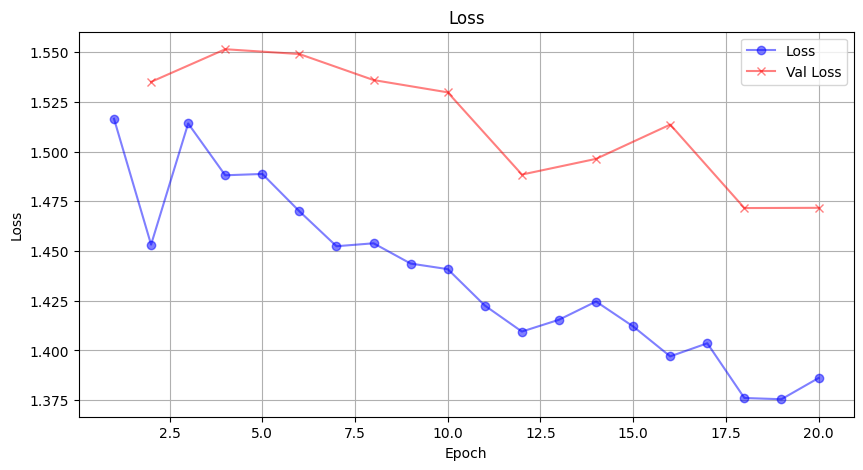

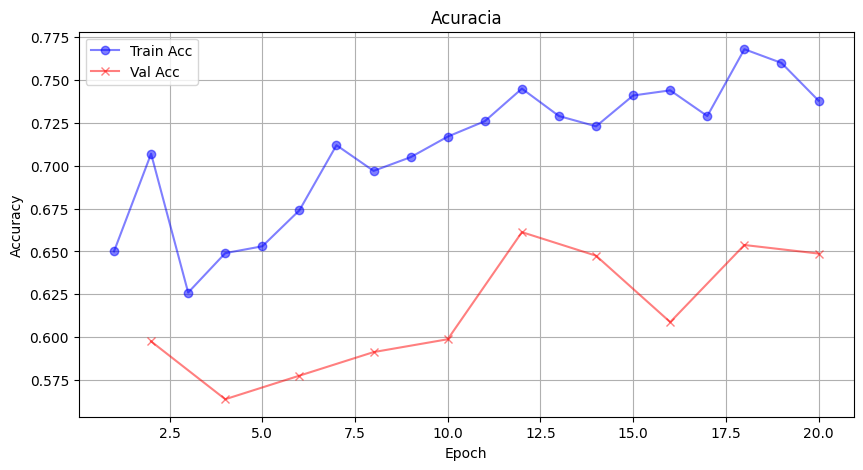

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, marker='o', color='blue', label="Loss", alpha=0.5)
plt.plot(val_epochs, val_loss, marker='x', color='red', label="Val Loss", alpha=0.5)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_acc, marker='o', color='blue', label="Train Acc", alpha=0.5)
plt.plot(val_epochs, val_acc, marker='x', color='red', label="Val Acc", alpha=0.5)
plt.title("Acuracia")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()